# Probabilistic ML: Assignment 2
- **Deadline**: 11:59PM February 19th 
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.
- **Version 1 (2/11)** Fixed typo in Q2.4.A docstring

# Q1 - Image Denoising

In this problem, we will implement the sum-product Loopy **belief propagation** (Loopy-BP) method for denoising binary images which you have seen in tutorial 4.
We will consider images as matrices of size $\sqrt{n} \times \sqrt{n}$. Each element of the matrix can be either $1$ or $-1$, with $1$ representing white pixels and $-1$ representing black pixels. This is different from the $0/1$ representation commonly used for other CV tasks. This notation will be more convenient when multiplying with pixel values.

### Data preparation
Below we provide you with code for loading and preparing the image data.

First, we load a black and white image of Laika and convert it into a binary matrix of 1 and -1. So that white pixels have value 1 and black pixels have value -1.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=a1250205b0de59c4bef0e788dff56d5348ffce042cf4fd336f3a23eb480e2067
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


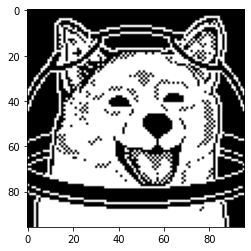

In [ ]:
!pip install wget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as Image
from os.path import exists
from wget import download
from tqdm import tqdm
filename, url = "3vaef0cog4f61.png", "https://i.redd.it/3vaef0cog4f61.png"

def load_img():
    if not exists(filename):
        download(url)

    with open(filename, 'rb') as fp:
        img2 = Image.open(fp).convert('L')
        img2 = np.array(img2)
    return (img2[:96,11:107] > 120) * 2.0 - 1

img_true = load_img()
plt.imshow(img_true, cmap='gray')

To introduce noise into the image, for each pixel, swap its value between 1 and -1 with rate 0.2. 


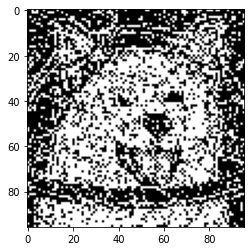

In [ ]:
def gen_noisyimg(img, noise=.05):
    swap = np.random.binomial(1, noise, size=img.shape)
    return img * (2 * swap - 1)

noise = 0.2
img_noisy = gen_noisyimg(img_true, noise)
plt.imshow(-1 * img_noisy, cmap='gray')

### The Loopy BP algorithm


Recall from lecture and tutorial, the Loopy-BP algorithm iteratively updates the messages of each node through a sum-product operation. The **sum-product** operation computes the joint inbound message through multiplication, and then marginalizes the factors through summation. This is in contrast to the **max-product** BP, which computes the maximum a-posteriori value for each variable through taking the maximum over variables.

Initialization:
 
For discrete node $x_j$ with $2$ possible states, $m_{i \rightarrow j}$ can be written as a $2$ dimensional real vector $\mathrm{m}_{i,j}$ with $m_{i \rightarrow j}(x_j) =  \mathrm{m}_{i,j}[index(x_j)]$. We initialize them uniformly to $m_{i \rightarrow j}(x_j) = 1/2$. 

(Aside: for continuous cases, $m_{i \rightarrow j}(x_j)$ is a real valued function of $x_j$. We only need to deal with the discrete case here.)

For a number of iterations:

&nbsp;&nbsp;&nbsp;&nbsp;For node $x_j$ in $\{x_s\}_{s=1}^n$:  
1. Compute the product of inbound messages from neighbours of $x_j$: 
$$\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)$$

2. Compute potentials $\psi_j(x_j) = \exp (\beta x_jy_j)$ and $\psi_{ij}(x_i,x_j) = \exp(J x_i x_j)$. This expression specifically holds when $x \in \{-1,+1\}$.

3. Marginalize over $x_j = \{-1, +1\}$ to get $m_{j \rightarrow i}(x_i)$:
$$
m_{j \rightarrow i}(x_i) = \sum_{x_j}\psi_j(x_j)\psi_{ij}(x_i, x_j)\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)
$$
4. Normalize messages for stability $m_{j \rightarrow i}(x_i) =m_{j \rightarrow i}(x_i)/\sum_{x_i}m_{j \rightarrow i}(x_i)$.

Compute beliefs after message passing is done.
$$
b(x_i) \propto \psi_i(x_i) \prod_{j \in \mathcal N(i)} m_{j \rightarrow i}(x_i).
$$


You'll be tasked to perform steps 1-3 in the iterations and computing the beliefs. We will provide you with helper functions for initialization, finding neighbours, and normalization.

### Initialization
Initialize the message between neighbor pixels uniformly as $m_{j→i}(x_i) = 1/k$. Since each pixel can only be 1 or -1, message has two values $m_{j→i}(1)$ and $m_{j→i}(-1)$. We also initialize hyperparameters $J$ and $\beta$.

In [ ]:
y = img_noisy.reshape([img_true.size, ])
num_nodes = len(y)
init_message = np.zeros([2, num_nodes, num_nodes]) + .5
J = 1.0
beta = 1.0

Find the neighboring pixels around a given pixel, which will be used for BP updates

In [ ]:
def get_neighbors_of(node):
    """
    arguments:
     int node:  in [0,num_nodes) index of node to query
    globals:
     int num_nodes: number of nodes
    return: set(int) indices of neighbors of queried node
    """
    neighbors = []
    m = int(np.sqrt(num_nodes))
    if (node + 1) % m != 0:
        neighbors += [node + 1]
    if node % m != 0:
        neighbors += [node - 1]
    if node + m < num_nodes:
        neighbors += [node + m]
    if node - m >= 0:
        neighbors += [node - m]

    return set(neighbors)

## Q1.1 Implement message passing in BP (20 pts)

Implement the function `get_message()` that computes the message passed from node j to node i: $$
m_{j \rightarrow i}(x_i) = \sum_{x_j}\psi_j(x_j)\psi_{ij}(x_i, x_j)\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)
$$
`get_message()` will be used by (provided below) `step_bp()` to perform one iteration of loopy-BP: it first normalizes the returned message from `get_message()`, and then updates the message with momentum `1.0 - step`.

In [ ]:
def get_message(node_from, node_to, messages):
    """
    arguments:
     int node_from: in [0,num_nodes) index of source node
     int node_from: in [0,num_nodes) index of target node
     float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
     float array y: (num_nodes,) observed pixel values
     float J: clique coupling strength constant
     float beta: observation to true pixel coupling strength constant
    return: array(float) of shape (2,) un-normalized message from node_from to 
    node_to
    """
    prod = [1, 1]
    neighbours = get_neighbors_of(node_from)
    for k in neighbours:
      if k != node_to:
        prod *= messages[:, k, node_from]
    
    import pdb; pdb.set_trace()

    edge_potentials = np.exp(J * np.array([[1, -1], [-1, 1]]))
    node_potentials = np.exp(beta * y[node_from] * np.array([1, -1]))
    return (node_potentials @ edge_potentials) * prod

def step_bp(step, messages):
    """
    arguments:
     float step: step size to update messages
    return
     float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    """
    for node_from in range(num_nodes):
        for node_to in get_neighbors_of(node_from):
            m_new = get_message(node_from, node_to, messages)
            # normalize
            m_new = m_new / np.sum(m_new)

            messages[:, node_from, node_to] = step * m_new + (1. - step) * \
                messages[:, node_from, node_to]
    return messages

Then, run loopy BP update for 10 iterations:

In [ ]:
num_iter = 10
step = 0.5
for it in range(num_iter):
    init_message = step_bp(step, init_message)
    print(it + 1,'/',num_iter)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.8/bdb.py", line 334, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-15-08b458f05b10>(23)get_message()
-> edge_potentials = np.exp(J * np.array([[1, -1], [-1, 1]]))
(Pdb) prod
array([0.99753246, 0.00246754])
(Pdb) n
> <ipython-input-15-08b458f05b10>(24)get_message()
-> node_potentials = np.exp(beta * y[node_from] * np.array([1, -1]))
(Pdb) n
> <ipython-input-15-08b458f05b10>(25)get_message()
-> return (node_potentials @ edge_potentials) * prod
(Pdb) edge_potentials
array([[2.71828183, 0.36787944],
       [0.36787944, 2.71828183]])
(Pdb) node_potentials
array([2.71828183, 0.36787944])
(Pdb) node_potentials @ edge_potentials
array([7.52439138, 2.        ])
(Pdb) (node_potentials @ edge_potentials) * prod
array([7.50582467e+00, 4.93507369e-03])


## Q1.2 Computing belief from messages (10 pts)

Now, calculate the unnormalized belief for each pixel 
$$ \tilde{b}(x_i) = \psi_i(x_i) ∏_{j \in N(i)}m_{j→i}(x_i),$$
and normalize the belief across all pixels
$$ b(x_i) = \frac{\tilde{b}(x_i)}{∑_{x_j}\tilde{b}(x_j)}.$$ 

In [ ]:
def update_beliefs(messages):
    """
    arguments:
    float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
     float beta: observation to true pixel coupling strength constant
     float array y: (num_nodes,) observed pixel values
    returns:
     float array beliefs: (2, num_nodes), beliefs[:,i] is the belief of node i
    """
    beliefs = np.zeros([2, num_nodes])
    for node in range(num_nodes):
        # Implement belief calculation here
        neighbours = get_neighbors_of(node)
        prod = [1, 1]
        for n in neighbours:
          prod *= messages[:, n, node]

        beliefs[:, node] = np.exp(beta * y[node] * np.array([1, -1])) * prod
        beliefs[:, node] /= np.sum(beliefs[:, node])

    return beliefs

# call update_beliefs() once
beliefs = update_beliefs(init_message)

Finally, to get the denoised image, we use 0.5 as the threshold and consider pixel with belief less than threshold as black while others as white. 

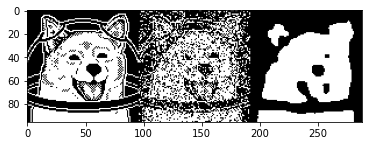

In [ ]:
pred = 2. * ((beliefs[1, :] > .5) + .0) - 1.
img_out = pred.reshape(img_true.shape)
    
plt.imshow(np.hstack([img_true, -1*img_noisy, img_out]), cmap='gray')

## Question 1.3 Momentum in belief propagation
In the sample code provided above, we performed message update with a momentum parameter `step`. In this question, you will experimentally investigate how momentum affects the characteristics of convergence.




### Question 1.3.1 (5 pts)
Complete the function `test_trajectory` below to obtain predicted image after each step of message passing. Return predicted images as list.

In [ ]:
def test_trajectory(step_size, max_step=10):
    """
    step_size: step_size to update messages in each iteration
    max_step: number of steps
    """
    # re-initialize each time
    messages = np.zeros([2, num_nodes, num_nodes]) + .5
    images = []

    # solution:
    for i in range(max_step):
      messages = step_bp(step_size, messages)
      beliefs = update_beliefs(messages)
      pred = 2. * ((beliefs[1, :] > .5) + .0) - 1.
      img_out = pred.reshape(img_true.shape)
      images.append(img_out)
      print(i + 1,'/',num_iter)

    return images

### Question 1.3.2 (5 pts)
Use test trajectory to create image serieses for `step size` 0.1, 0.3, and 1.0, each with 10 steps. Display these images with `plot_series' provided below. 

In the textbox below, 1. comment on what happens when a large step size is used for too many iterations. 2. how would you adjust other hyperparameters to counteract this effect?

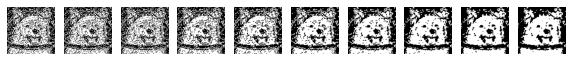

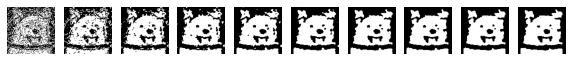

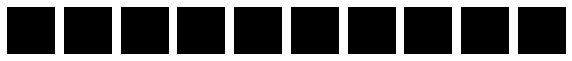

In [ ]:
def plot_series(images):
  n = len(images)
  fig, ax = plt.subplots(1, n)
  for i in range(n):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_axis_off()
  fig.set_figwidth(10)
  fig.show()

#Solution:
images = test_trajectory(0.1, max_step=10)
plot_series(images)
images = test_trajectory(0.3, max_step=10)
plot_series(images)
images = test_trajectory(1.0, max_step=10)
plot_series(images)

### Response to 1.3.2 (Enter your response below):
We can see that when using a larger step size like 1.0, the image is entirely black. This is because when we use the step size, 

```
messages[:, node_from, node_to] = step * m_new + (1. - step) * \
                messages[:, node_from, node_to]
```
If `step_size` is 1 then `1. - step` is 0, meaning that `messages[:, node_from, node_to] = step * m_new`. So it is only counting the normalized, and not the unnormalized messages. I don't think this can be fixed by adjusting other hyperparameters.

## Question 1.4 Noise level, $beta$ and overfitting.
In this question, we will study how the level of noise in the image influences our choice in the hyperparameter $\beta$.

### Question 1.4.1 (5 pts)
First, generate and display images with noise of $0.05$, $0.3$.
In the text box below, comment on what would happen if noise was set to $0.5$ and $1.0$

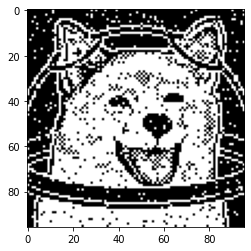

In [ ]:
# Solution
img_noisy = gen_noisyimg(img_true, 0.05)
plt.imshow(-1 * img_noisy, cmap='gray')

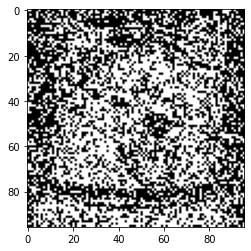

In [ ]:
img_noisy = gen_noisyimg(img_true, 0.3)
plt.imshow(-1 * img_noisy, cmap='gray')

### Response to 1.4.1 (enter your response below):

We swap the pixel value from 1 to -1 and vice versa with rate equal to the noise. So if the noise is set to 0.5, it would be similar to 0.3, but more amalgamated. If it was set to 1, it would simply be the same image but all the 1 pixels are -1, and vice-versa. So the colours would be swapped.

### Question 1.4.2 (5 pts)
Now, perform image denoising on images with noise levels $0.05$ and $0.3$ using $\beta=0.5$, $\beta=1.0$, $\beta=2.5$, and $\beta=5.0$. Set step size to 0.8 and max_step to 5. Plot the denoised images (if reusing `test_trajectory`, you should plot 8 image serieses).
In text box below, comment on what you observe and provide a brief explanation on why this might occur.

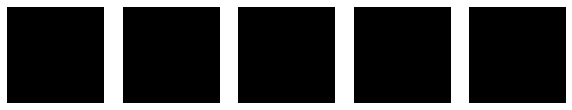

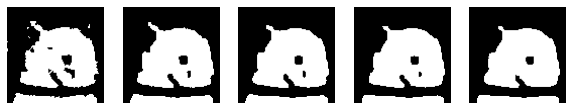

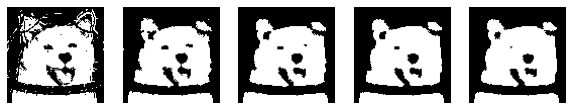

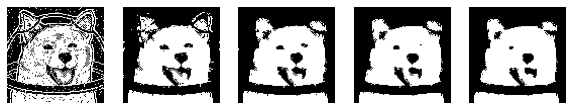

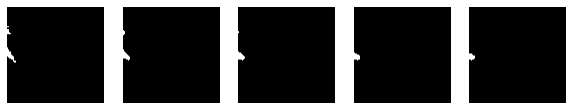

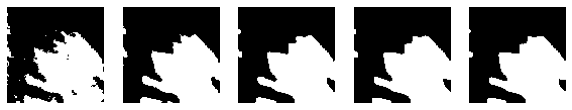

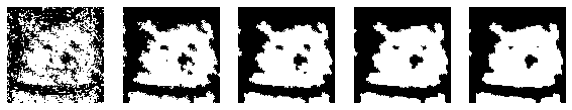

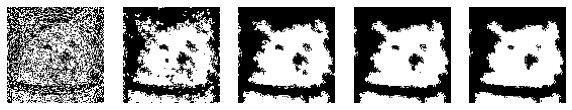

In [ ]:
# Solution

def perform(step_size, max_step):
    """
    step_size: step_size to update messages in each iteration
    max_step: number of steps
    """
    message = np.zeros([2, num_nodes, num_nodes]) + .5
      
    images = test_trajectory(step_size, max_step)
    plot_series(images)

# noise = 0.05
noise = 0.05
img_noisy = gen_noisyimg(img_true, noise)
y = img_noisy.reshape([img_true.size, ])
num_nodes = len(y)
beta = 0.5
perform(0.8, 5)

beta = 1.0
perform(0.8, 5)

beta = 2.5
perform(0.8, 5)

beta = 5.0
perform(0.8, 5)

# noise = 0.3
noise = 0.3
img_noisy = gen_noisyimg(img_true, noise)
y = img_noisy.reshape([img_true.size, ])
num_nodes = len(y)
beta = 0.5
perform(0.8, 5)

beta = 1.0
perform(0.8, 5)

beta = 2.5
perform(0.8, 5)

beta = 5.0
perform(0.8, 5)

### Response to 1.4.2 (enter your response below):
We can see that increasing $\beta$ gives us worse results as we run for more steps. For example, take when $\beta = 5.0$ and the noise was 0.05. We can see that the more steps we run for, the less dog the picture looks. This could be because $\beta$ is used in the calculation for node potentials.

# Question 2: Markov chain Monte Carlo in the TrueSkill model

The goal of this question is to get you familiar with the basics of
Bayesian inference in medium-sized models with continuous latent variables, and the basics of Hamiltonian Monte Carlo.

## Background

We'll implement a variant of the [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2.
It is a generalization of the Elo rating system in Chess.

This assignment is based on [this one](http://mlg.eng.cam.ac.uk/teaching/4f13/1920/) developed by Carl Rasmussen at Cambridge for his course on probabilistic machine learning.

## Model definition
We'll consider a slightly simplified version of the original trueskill model.
We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are \emph{a priori} independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch 
import random
from torch.distributions.normal import Normal

from functools import partial

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
  # axis=-1 means sum over the last dimension.
  m = Normal(mu, std)
  return torch.sum(m.log_prob(x), axis=-1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Q2.1 Implementing the TrueSkill Model (10 pts)

###	Q 2.1.a [5 points]
Implement a function $\texttt{log_joint_prior}$ that computes the log of the prior, jointly evaluated over all player's skills.

  Specifically, given a $K \times N$ array where each row is a setting of the skills for all $N$ players, it returns a $K \times 1$ array, where each row contains a scalar giving the log-prior for that set of skills.

In [ ]:
def log_joint_prior(zs_array):
  # Hint: Use diag_gaussian_log_density
  return diag_gaussian_log_density(zs_array, 0.0, 1.0)

### Q 2.1.b [5 points]

Implement two functions $\texttt{logp_a_beats_b}$ and $\texttt{logp_b_beats_a}$. 

Given a pair of skills $z_a$ and $z_b$, $\texttt{logp_a_beats_b}$ evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above, and $\texttt{logp_b_beats_a}$ is vice versa.

To ensure numerical stability, use the function $torch.logaddexp$


In [ ]:
def logp_a_beats_b(z_a, z_b):
  # Hint: Use torch.logaddexp
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_b - z_a))

def logp_b_beats_a(z_a, z_b):
  # Hint: Use torch.logaddexp
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_a - z_b))

## Q 2.2 Examining the posterior for only two players and toy data (10 pts)
To get a feel for this model, we'll first consider the case where we only have 2 players, $A$ and $B$.
We'll examine how the prior and likelihood interact when conditioning on different sets of games.

Provided in the starter code is a function $\texttt{skillcontour}$ which evaluates a provided function on a grid of $z_A$ and $z_B$'s and plots the isocontours of that function.
As well there is a function $\texttt{plot_line_equal_skill}$. 
We have included an example for how you can use these functions.

We also provided a function $\texttt{two_player_toy_games}$ which produces toy data for two players.
I.e. $\texttt{two_player_toy_games(5,3)}$ produces a dataset where player A wins 5 games and player B wins 3 games.


In [ ]:
# Plotting helper functions
def plot_isocontours(ax, func, steps=100):
    x = torch.linspace(-4, 4, steps=steps)
    y = torch.linspace(-4, 4, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    #Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z )
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()
    

### Q 2.2.a [3 points]
For two players $A$ and $B$, plot the isocontours of the joint prior over their skills.  Also plot the line of equal skill, $z_A = z_B$.  You've already implemented the log of this function, you just need to graph it using the helper function `plot_2d_fun` above.

For this and the following plots, label both axes.

According to the prior, what's the chance that player A is better than player B?

Answer: We know nothing about the skills of the players, so the chance of player A being better than player B is the same as the chance of player B being better than player A which is 50%.

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


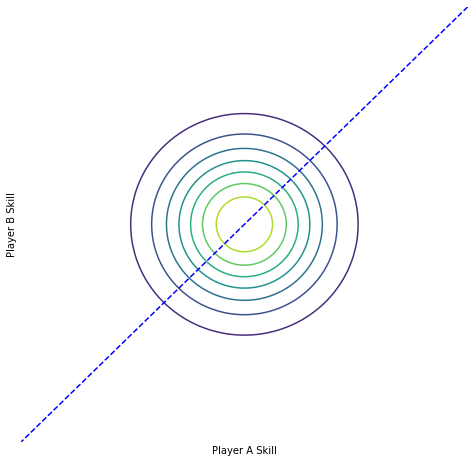

<Figure size 432x288 with 0 Axes>

In [ ]:
def log_prior_over_2_players(z1, z2):
  #return z1+z2
  m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
  return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
  return np.exp(log_prior_over_2_players(z1, z2))

plot_2d_fun(prior_over_2_players, "Player A Skill", "Player B Skill")

<ipython-input-7-07e038d7c827>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_b - z_a))


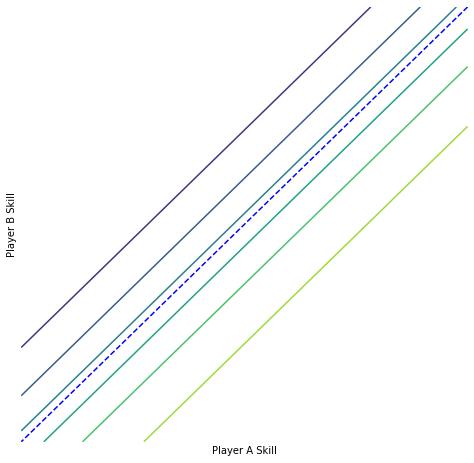

<Figure size 432x288 with 0 Axes>

In [ ]:
# Note:  This isn't part of the assignment
def likelihood_over_2_players(z1, z2):
  return torch.exp(logp_a_beats_b(z1, z2))

plot_2d_fun(likelihood_over_2_players, "Player A Skill", "Player B Skill")

### Q 2.2.b [3 points]

Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that player A
beat player B in one match.  Since the contours don't depend on the normalization
constant, you can simply plot the isocontours of the log of joint distribution of
$p(z_A, z_B, \text{A beat B})$
Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, which player is likely to have higher skill?

Answer: player A is likely to have higher skill.

<ipython-input-7-07e038d7c827>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_b - z_a))


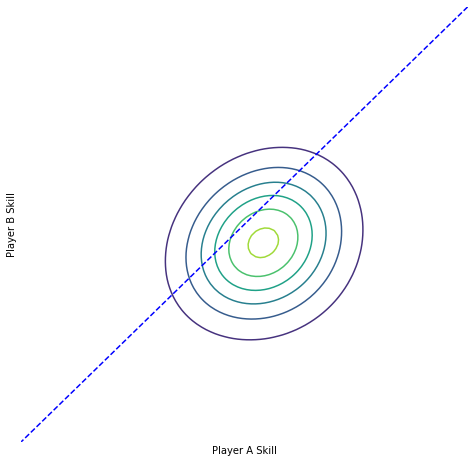

<Figure size 432x288 with 0 Axes>

In [ ]:
def log_posterior_A_beat_B(z1, z2):
  # TODO: Combine the prior for two players with the likelihood for A beat B.
  # You might want to use the log_prior_over_2_players function from above.
  return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
  return torch.exp(log_posterior_A_beat_B(z1, z2))

plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill")

### Q 2.2.c [2 points]

Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that
10 matches were played, and player A beat player B all 10 times.
Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, is it plausible that player B is more skilled than player A?

Answer: No it is not plausible that player B is more skilled than player A. The isocountour is way below the line of equal skill.

<ipython-input-7-07e038d7c827>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_b - z_a))


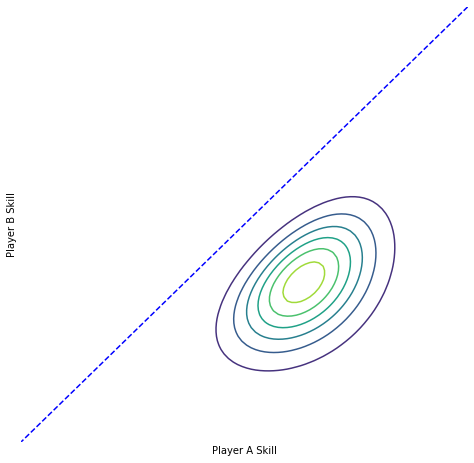

<Figure size 432x288 with 0 Axes>

In [ ]:
def log_posterior_A_beat_B_10_times(z1, z2):
  # TODO: Combine the prior for two players with the likelihood for A beat B.
  # You might want to use your log_prior_over_2_players function from above.
  return log_prior_over_2_players(z1, z2) + 10 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
  return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill")

### Q 2.2.d [2 point]

Plot isocontours of the joint posterior over $z_A$ and $z_B$ given that
20 matches were played, and each player beat the other 10 times.
Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, is it likely that one player is much better than another?  Is it plausible that both players are better than average?  Worse than average?

Answer: The players are about the same in terms of skill. 

<ipython-input-7-07e038d7c827>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_b - z_a))
<ipython-input-7-07e038d7c827>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_a - z_b))


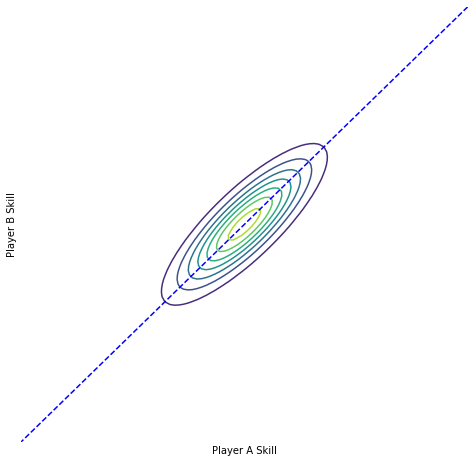

<Figure size 432x288 with 0 Axes>

In [ ]:
def log_posterior_beat_each_other_10_times(z1, z2):
  # TODO: Combine the prior for two players with the likelihood for A beat B.
  # You might want to use your log_prior_over_2_players function from above.
  return log_prior_over_2_players(z1, z2) + 10 * logp_a_beats_b(z1, z2) + 10 * logp_b_beats_a(z1, z2)

def posterior_beat_each_other_10_times(z1, z2):
  return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))
plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill")

## Q 2.3 Hamiltonian Monte Carlo on Two Players and Toy Data (6 points)

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.
Carl Rasmussen's assignment uses Gibbs sampling.

In this question we will  approximate posterior distributions with gradient-based Hamiltonian Monte Carlo.

In the next assignment, we'll use gradient-based stochastic variational inference, which wasn't invented until around 2014. 


In [ ]:
random.seed(0)


In [ ]:
# Hamiltonian Monte Carlo
from tqdm import trange, tqdm_notebook  # Progress meters

def leapfrog(params_t0, momentum_t0, stepsize, logprob_grad_fun):
  # Performs a reversible update of parameters and momentum
  # See https://en.wikipedia.org/wiki/Leapfrog_integration
  momentum_thalf = momentum_t0    + 0.5 * stepsize * logprob_grad_fun(params_t0)
  params_t1 =      params_t0      +       stepsize * momentum_thalf
  momentum_t1 =    momentum_thalf + 0.5 * stepsize * logprob_grad_fun(params_t1)
  return params_t1, momentum_t1


def iterate_leapfrogs(theta, v, stepsize, num_leapfrog_steps, grad_fun):
  for i in range(0, num_leapfrog_steps):
    theta, v = leapfrog(theta, v, stepsize, grad_fun)
  return theta, v

def metropolis_hastings(state1, state2, log_posterior):
  # Compares the log_posterior at two values of parameters,
  # and accepts the new values proportional to the ratio of the posterior
  # probabilities.
  accept_prob = torch.exp(log_posterior(state2) - log_posterior(state1))
  if random.random() < accept_prob:
    return state2  # Accept
  else:
    return state1  # Reject

def draw_samples(num_params, stepsize, num_leapfrog_steps, n_samples, log_posterior):
  theta = torch.zeros(num_params)

  def log_joint_density_over_params_and_momentum(state):
    params, momentum = state
    return diag_gaussian_log_density(momentum, torch.zeros_like(momentum), torch.ones_like(momentum)) \
     + log_posterior(params)

  def grad_fun(zs):
    zs = zs.detach().clone()
    zs.requires_grad_(True)
    y = log_posterior(zs)
    y.backward()
    return zs.grad



  sampleslist = []
  for i in trange(0, n_samples):
    sampleslist.append(theta)

    momentum = torch.normal(0, 1, size = np.shape(theta))
    
    theta_new, momentum_new = iterate_leapfrogs(theta, momentum, stepsize, num_leapfrog_steps, grad_fun)
  
    theta, momentum = metropolis_hastings((theta, momentum), (theta_new, momentum_new), log_joint_density_over_params_and_momentum)
  return torch.stack((sampleslist))


### Q 2.3.a [Free]

Using samples generated by HMC, approximate the joint posterior where we observe player A winning 1 game.

  0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-7-07e038d7c827>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_b - z_a))
100%|██████████| 2000/2000 [01:01<00:00, 32.45it/s]


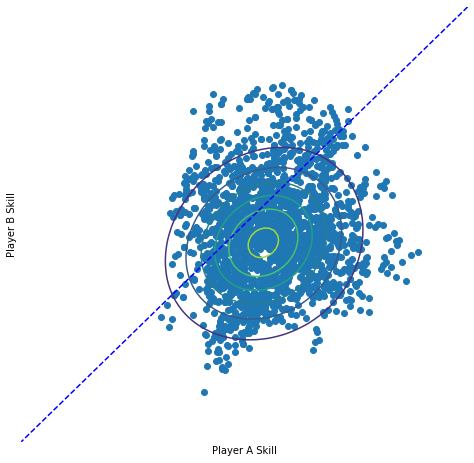

<Figure size 432x288 with 0 Axes>

In [ ]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2000
stepsize = 0.01


def log_posterior_a(zs):
  return log_posterior_A_beat_B(zs[0], zs[1])

samples_a = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_a)
plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill", samples_a)

### Q 2.3.b [3 point]}

Using samples generated by HMC, approximate the joint posterior where we observe player A winning 10 games against player B.  Hint:  You can re-use the code from when you plotted the isocontours.

  0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-7-07e038d7c827>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_b - z_a))
100%|██████████| 2000/2000 [01:19<00:00, 25.09it/s]


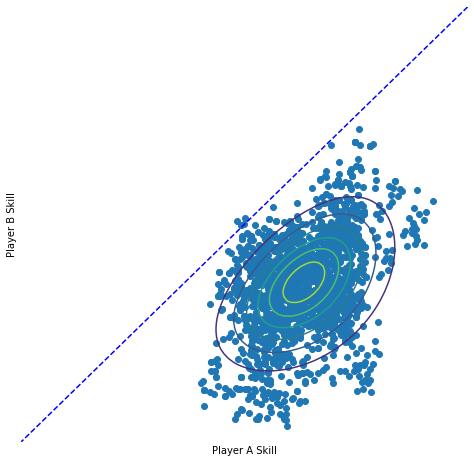

<Figure size 432x288 with 0 Axes>

In [ ]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2000
stepsize = 0.01
key = 42


def log_posterior_b(zs):
  return log_posterior_A_beat_B_10_times(zs[0], zs[1])

samples_b = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_b)
ax = plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill", samples_b)
ax

### Q 2.3.c [3 points]}

Using samples generated by HMC, approximate the joint posterior where we observe player A winning 10 games and player B winning 10 games.

  0%|          | 0/2000 [00:00<?, ?it/s]<ipython-input-7-07e038d7c827>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_b - z_a))
<ipython-input-7-07e038d7c827>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_a - z_b))
100%|██████████| 2000/2000 [00:59<00:00, 33.67it/s]


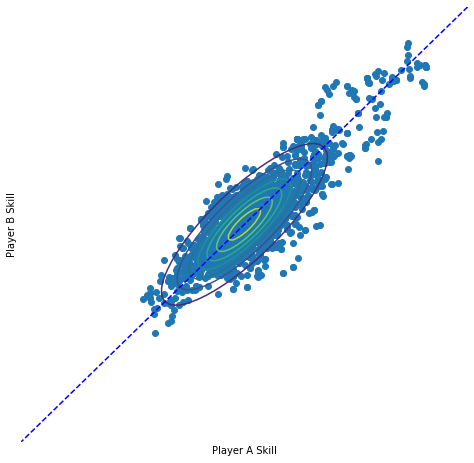

<Figure size 432x288 with 0 Axes>

In [ ]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2000
stepsize = 0.01


def log_posterior(zs):
  return log_posterior_beat_each_other_10_times(zs[0], zs[1])

samples_c = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior)
ax = plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill", samples_c)
ax

## Q 2.4 Approximate inference conditioned on real data [26 points]

The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [ ]:
wget.download("https://erdogdu.github.io/sta414/hw/hw2/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_index", "loser_index"]].to_numpy()
wget.download("https://erdogdu.github.io/sta414/hw/hw2/chess_players.csv")
names = pd.read_csv("chess_players.csv")[["index", "player_name"]].to_numpy()

In [ ]:
games = torch.IntTensor(games)

### Q 2.4.a.1 [4 points]

Assuming all game outcomes are i.i.d. conditioned on all players' skills, implement a function $\texttt{log_games_likelihood}$ that takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihoods for all those observations given all the skills.

Hint: You should be able to write this function without using $\texttt{for}$ loops, although you might want to start that way to make sure what you've written is correct.  If $A$ is an array of integers, you can index the corresponding entries of another matrix $B$ for every entry in $A$ by writing $\texttt{B[A]}$.

In [ ]:
def log_games_likelihood(zs, games):
  # games is an array of size (num_games x 2)
  # zs is an array of size num_players
  #
  # Hint: With broadcasting, this function can be written
  # with no for loops.
  #
  winning_player_ixs = games[:,0]
  losing_player_ixs = games[:,1]

  winning_player_ixs = winning_player_ixs.type(torch.int64)
  losing_player_ixs = losing_player_ixs.type(torch.int64)

  winning_player_skills = zs.gather(0, winning_player_ixs)    #TODO: Look up the skill of the winning player in each game.
  losing_player_skills = zs.gather(0, losing_player_ixs)    #TODO: Look up the skills of the losing player in each game.

  log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)          #TODO: Compute the log_likelihood of each game outcome.
  return torch.sum(log_likelihoods)                     #TODO: Combine the log_likelihood of independent events.

  
## Q 2.4.a.2) [3 points]
Implement a function $\texttt{joint_log_density}$ which combines the log-prior and log-likelihood of the observations to give $p(z_1, z_2, \dots, z_N, \text{all game outcomes})$

In [ ]:
def log_joint_probability(zs, games):
    # Combine log_prior and log_likelihood.
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

### Q 2.4.b [3 points]
Run Hamiltonian Monte Carlo on the posterior over all skills conditioned on all the tennis games from the dataset.  Run for 10000 samples.

In [ ]:
# Hyperparameters
num_players = 1434
num_leapfrog_steps = 20
n_samples = 10000
stepsize = 0.01

#Hint: you will need to use games
def log_posterior(zs):
  return log_joint_probability(zs, games)

all_games_samples = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-7-07e038d7c827>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -torch.logaddexp(torch.tensor(0.0), torch.tensor(z_b - z_a))
100%|██████████| 10000/10000 [06:20<00:00, 26.29it/s]


### Q 2.4.c [3 points]
Based on your samples from the previous question, plot the approximate mean and variance of the marginal skill of each player, sorted by average skill. There's no need to include the names of the players.  Label the axes "Player Rank", and "Player Skill".

<ErrorbarContainer object of 3 artists>

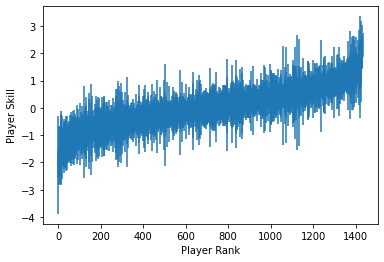

In [ ]:
mean_skills = torch.mean(all_games_samples, axis=0)
var_skills = torch.var(all_games_samples, axis=0)

order = np.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills[order], var_skills[order])

### Q 2.4.d [3 point]
List the names of the 5 players with the lowest mean skill and 5 players with the highest mean skill according to your samples.  Hint: you can re-use `order` from the previous question.

In [ ]:
print('---lowest---')
for i in range(5):
  print(names[order[-i]])
print('---highest---')
for i in range(5):
  print(names[order[i]])

---lowest---
[169 'chaose']
[209 'cameronl86']
[1121 'hick4u1219']
[820 'smartduckduckcow']
[885 'sailor7']
---highest---
[169 'chaose']
[0 'lukarpov']
[602 'busy']
[1245 'javi_r']
[95 'kellyclarkson']


### Q 2.4.e [3 point]
Use a scatterplot to show your samples from the joint posterior over the skills of lelik3310 and thebestofthebad.  Include the line of equal skill.  Hint: you can use `plt.scatter`.


Text(0, 0.5, 'Player Skill')

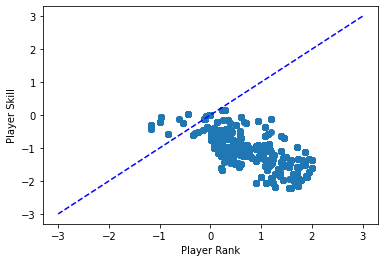

In [ ]:
lelik3310_ix = 496
thebestofthebad_ix = 512


plt.plot([3, -3], [3, -3], 'b--')
plt.scatter(all_games_samples[:, lelik3310_ix], all_games_samples[:, thebestofthebad_ix])
plt.xlabel("Player Rank")
plt.ylabel("Player Skill")

### Q 2.4.f [3 points]
Using your samples, find the players that have the eleventh highest mean skill. Print an unbiased estimate of the probability that the player with the eleventh highest highest mean skill is not worse than lelik3310, again as estimated from your samples.  Hint: Probabilities of Bernoulli random variables can be written as the expectation that the Bernoulli takes value 1, so you can use simple Monte Carlo.  The final formula will be very simple.

In [ ]:
eleventh_players = all_games_samples[all_games_samples[:, order[11]] < all_games_samples[:, lelik3310_ix]]
torch.mean(eleventh_players)

tensor(0.0127)

### Q 2.4.g [2 points]

For any two players $i$ and $j$, $p(z_i, z_j | \text{all games})$ is always proportional to $p(z_i, z_j , \text{all games})$, as a function of $z_i$ and $z_j$.

In general, are the isocontours of $p(z_i, z_j | \text{all games})$ the same as those of $p(z_i, z_j | \text{games between $i$ and $j$})$?  That is, do the games between other players besides $i$ and $j$ provide information about the skill of players $i$ and $j$?  A simple yes or no suffices.

Hint: One way to answer this is to draw the graphical model for three players, $i$, $j$, and $k$, and the results of games between all three pairs, and then examine conditional independencies.  If you do this, include the graphical models in your assignment.

Your answer here: No. Because the games between other players besides $i$ and $j$ provide information about the skill of players $i$ and $j$.